# Evaluation of CO and FHMM Models

We will test the disaggregation models previously trained in earlier phases, for which we should use a dataset different from the one used in training, in order to apply the metrics provided by NILMTK.

First, we load the libraries and make other adjustments:


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Validation Set

We now take a time slot for validation that has not been used for training

In [2]:
#Set para validación
valid = DataSet('dsualmh.h5')



valid.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")

valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='dsualmh', appliances=[Appliance(type='electric shower heater', instance=1)])
  El

Now we label all meters

In [3]:

labels = pd.DataFrame({'Instances': list(range(1,12)),
                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Incandescent Lamp','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})

print ("** Etiquetas ***")


print (labels)

Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

** Etiquetas ***
    Instances                  Meters
0           1                    Main
1           2        Electric furnace
2           3               Microwave
3           4              Television
4           5       Incandescent Lamp
5           6          Vacuum cleaner
6           7   Electric space heater
7           8  Electric shower heater
8           9                     Fan
9          10                  Fridge
10         11                 Freezer


And now we will display the validation data for the main meter

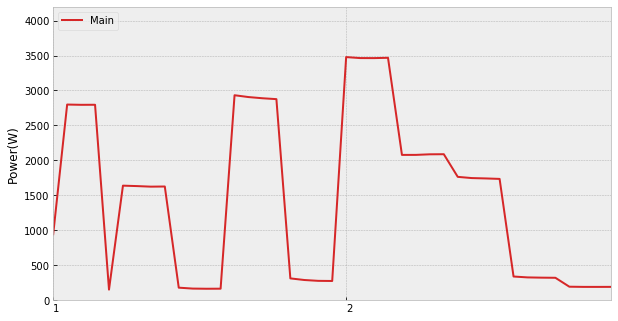

In [4]:
rcParams['figure.figsize'] = (10, 6)


#valid.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")

t0='2023-06-09 12:55:00+02:00'
t1='2023-06-09 13:16:00+02:00'
t2='2023-06-09 13:36:00+02:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

Similarly, we can also view the aggregation of the different meters.

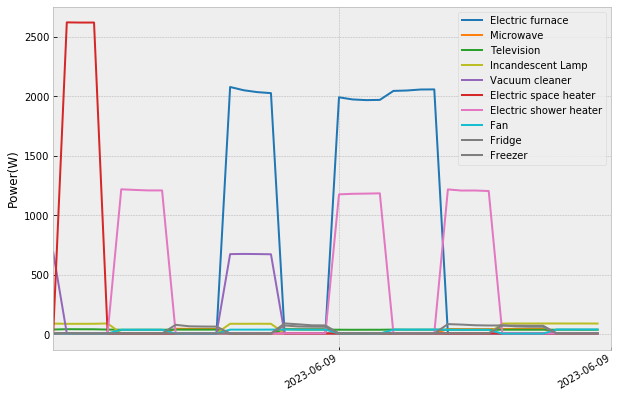

In [5]:
rcParams['figure.figsize'] = (10, 7)


ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:red','tab:pink','tab:cyan','tab:gray','tab:grey']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[1:11])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
#ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Disaggregation for validation

The disaggregation of validation data is performed using the data from the valid_Main MeterGroup, which contains the ElecMeter of the aggregated data from the electrical system. Thus, the main meter will be the input data for each of the trained disaggregation models.

Let's look at the disaggregation using different sampling periods, different methods and two of the most typical algorithms such as the Combinatorial algorithm (CO) and the Hidden Markov Model (FHMM).

In [6]:
train = DataSet('dsualmh.h5')


train.set_window(start="2023-06-09 09:34:00", end="2023-06-09 12:54:00")


train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM


#periods = {'1s':1, '10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

periods = {  '90s':90, '5min':60*5, '10min':60*10}

methods = ['mean', 'median','first']

#solo si tarda mucho en ejecutarse
#periods = {'1s':10}
#methods = ['mean']

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #falla al exportarlo como model.pickle asi que lo guardamos en formato h5
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.h5'
            #model_dir='prueba.pickle'
            #model.export_model(model_dir) 
            
            model_dir=data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5'
            output=HDFDataStore(model_dir, 'w')
            print ('Fichero del modelo:',model_dir)
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            
            #fichaje de los tiempos consumidos
            #end = time.time()-start
            #t.append(round(end,2))
            #print ('Tiempos de proceso:',t)
            
    times[sp_name] = t #tiempo de simulación
   
    
#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])

#times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean'])
    
    
print('\n\nDone!')

******************** CO 90s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='dsualmh', appliances

In [7]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
90s,3.01,14.94,2.90,14.69,2.92,14.70
5min,2.85,5.75,3.20,4.22,3.11,4.03
10min,3.19,4.09,3.17,4.10,3.25,4.22


## Model Generation Using CO Algorithm

In [8]:
train = DataSet('dsualmh.h5')


train.set_window(start="2023-06-09 09:34:00", end="2023-06-09 12:54:00")


train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM


periods = {'1s':1, '15s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

#periods = {  '90s':90, '5min':60*5, '10min':60*10}

methods = ['mean', 'median','first']

#solo si tarda mucho en ejecutarse
#periods = {'1s':10}
#methods = ['mean']

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #falla al exportarlo como model.pickle asi que lo guardamos en formato h5
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.h5'
            #model_dir='prueba.pickle'
            #model.export_model(model_dir) 
            
            model_dir=data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5'
            output=HDFDataStore(model_dir, 'w')
            print ('Fichero del modelo:',model_dir)
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            
            #fichaje de los tiempos consumidos
            #end = time.time()-start
            #t.append(round(end,2))
            #print ('Tiempos de proceso:',t)
            
    times[sp_name] = t #tiempo de simulación
   
    
#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean',  'CO_median', 'CO_first'])

#times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean'])
    
    
print('\n\nDone!')

******************** CO 1s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='dsualmh', appliances=

### Comparison of Results

## Mean Method

We will use two results files (CO and FHMM 60s - mean) to visualize the predictions made by the models and compare them with the actual device measurements in each case.

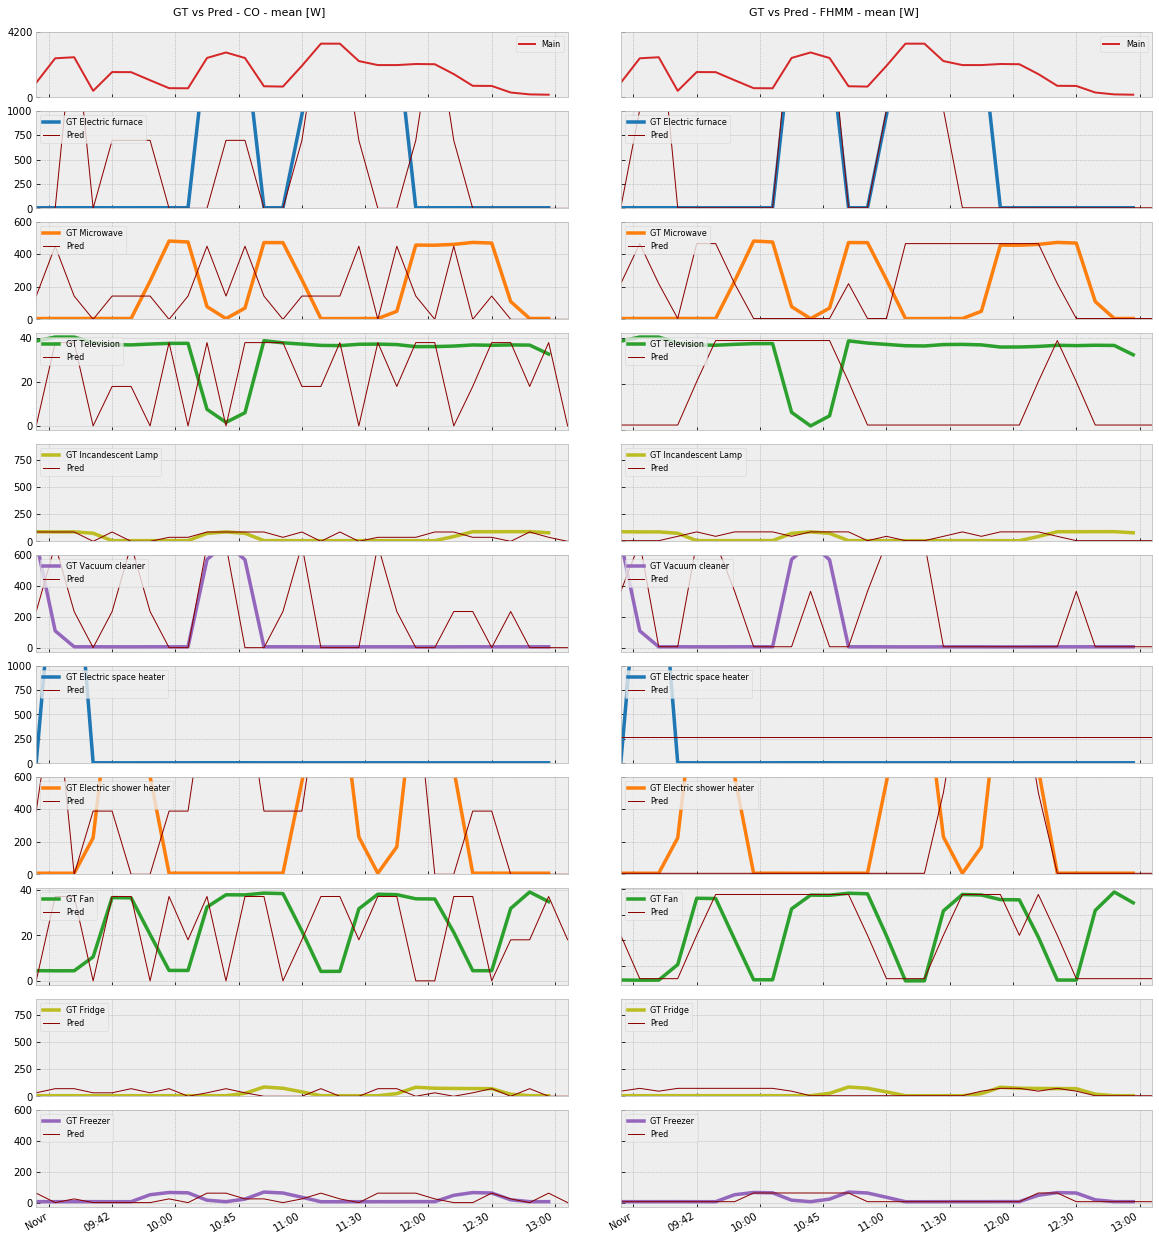

In [9]:
#resultados de predicción modelo CO 90s
CO_90s_first=DataSet(data_dir+'NILM/Results/CO_90s_mean_pred.h5')
elec_CO_90s_first=CO_90s_first.buildings[1].elec

#resultados de predicción modelo FHMM 90s
FHMM_90s_first=DataSet(data_dir+'NILM/Results/FHMM_90s_mean_pred.h5')
elec_FHMM_90s_first= FHMM_90s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=90, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_90s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_90s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='90s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
      

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])       
     

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_90s.svg', bbox_inches='tight', transparent=True)
pass

## 5 min

We will use two results files (CO and FHMM 5min - mean) to visualize the predictions made by the models and compare them with the actual device measurements in each case.

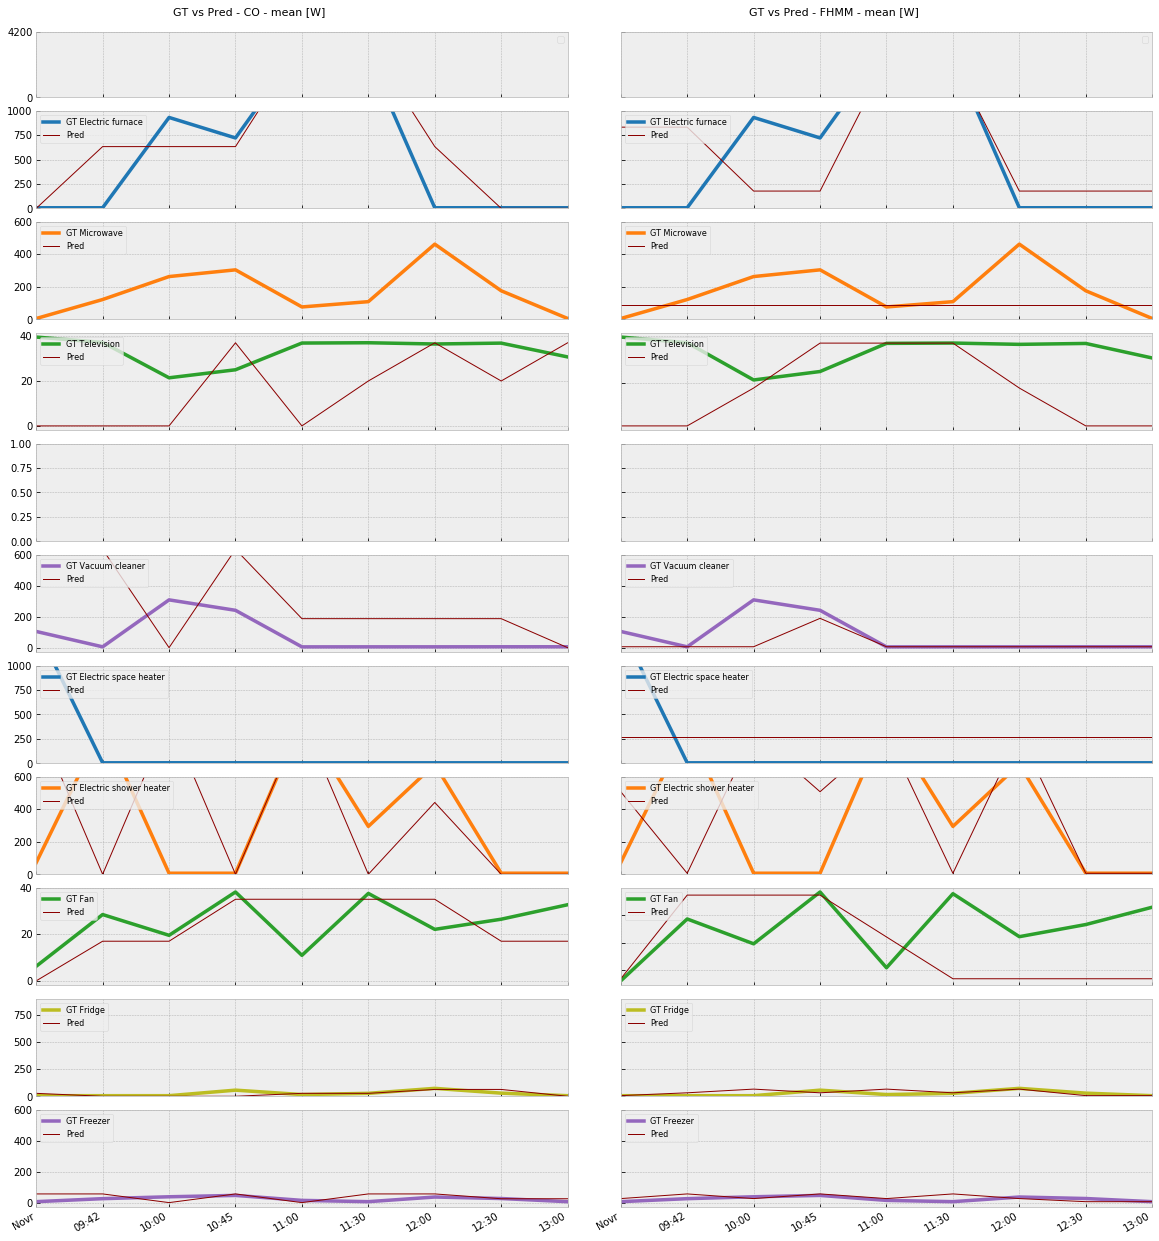

In [10]:
#resultados de predicción modelo CO 5min
CO_5min_first=DataSet(data_dir+'NILM/Results/CO_5min_mean_pred.h5')
elec_CO_5min_first=CO_5min_first.buildings[1].elec

#resultados de predicción modelo FHMM 1s
FHMM_5min_first=DataSet(data_dir+'NILM/Results/FHMM_5min_mean_pred.h5')
elec_FHMM_5min_first= FHMM_5min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=300, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_5min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_5min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='5min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      





for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
  

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_5min.svg', bbox_inches='tight', transparent=True)
pass

## 10 min

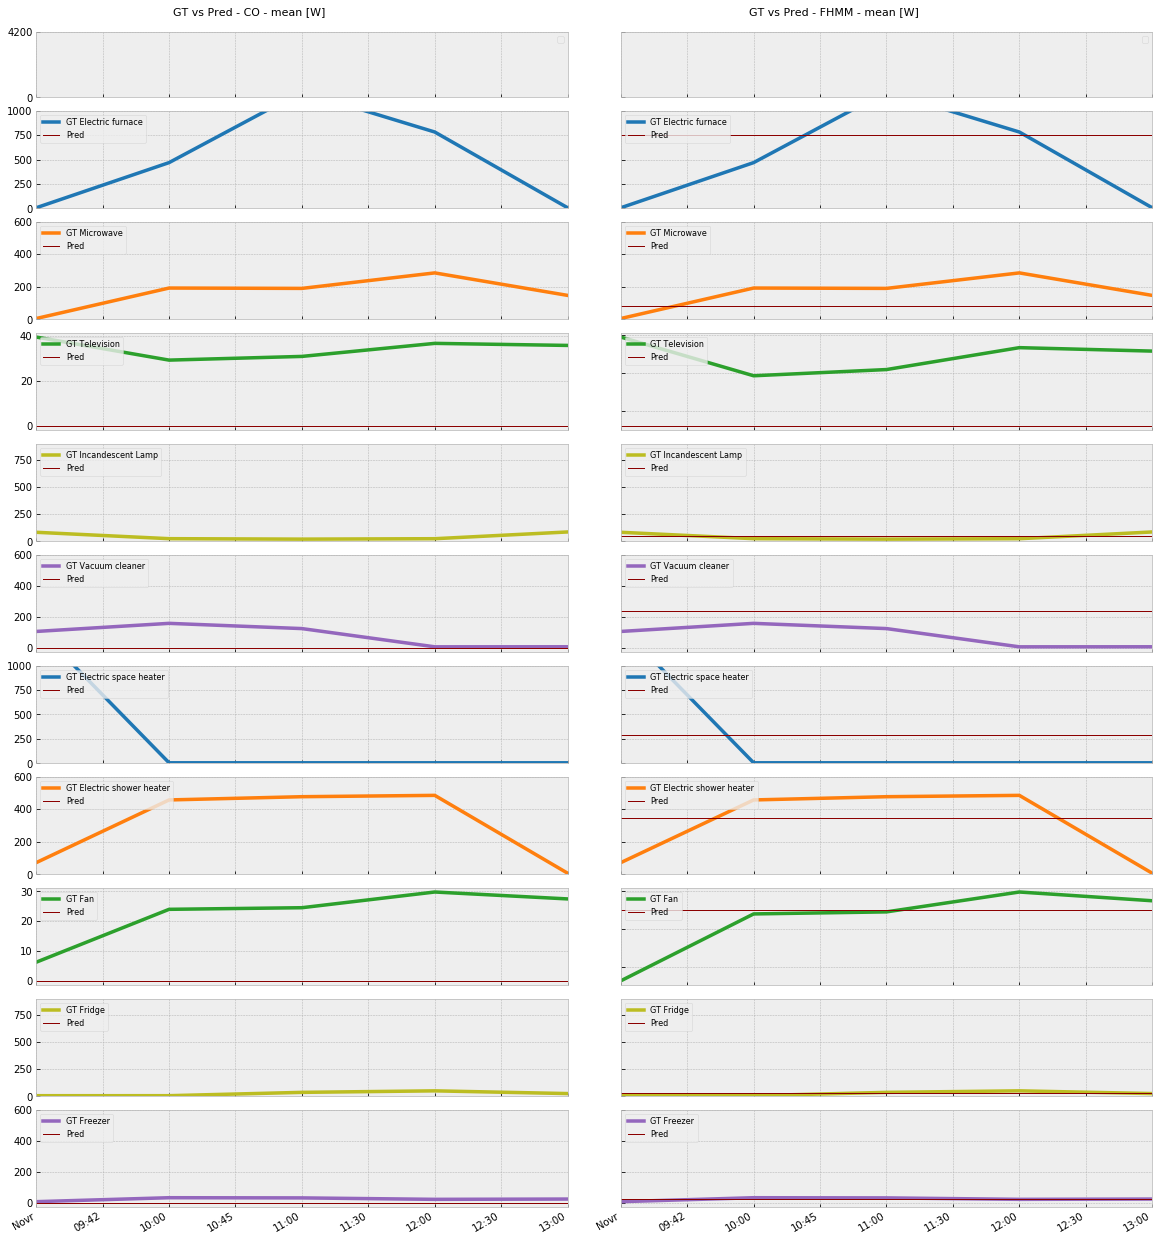

In [11]:
#resultados de predicción modelo CO 15min
CO_10min_first=DataSet(data_dir+'NILM/Results/CO_10min_mean_pred.h5')
elec_CO_10min_first=CO_10min_first.buildings[1].elec
#resultados de predicción modelo FHMM 15min
FHMM_10min_first=DataSet(data_dir+'NILM/Results/FHMM_10min_mean_pred.h5')
elec_FHMM_10min_first= FHMM_10min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=600, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_10min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_10min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='10min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      





for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_10min.svg', bbox_inches='tight', transparent=True)
pass

##  median method

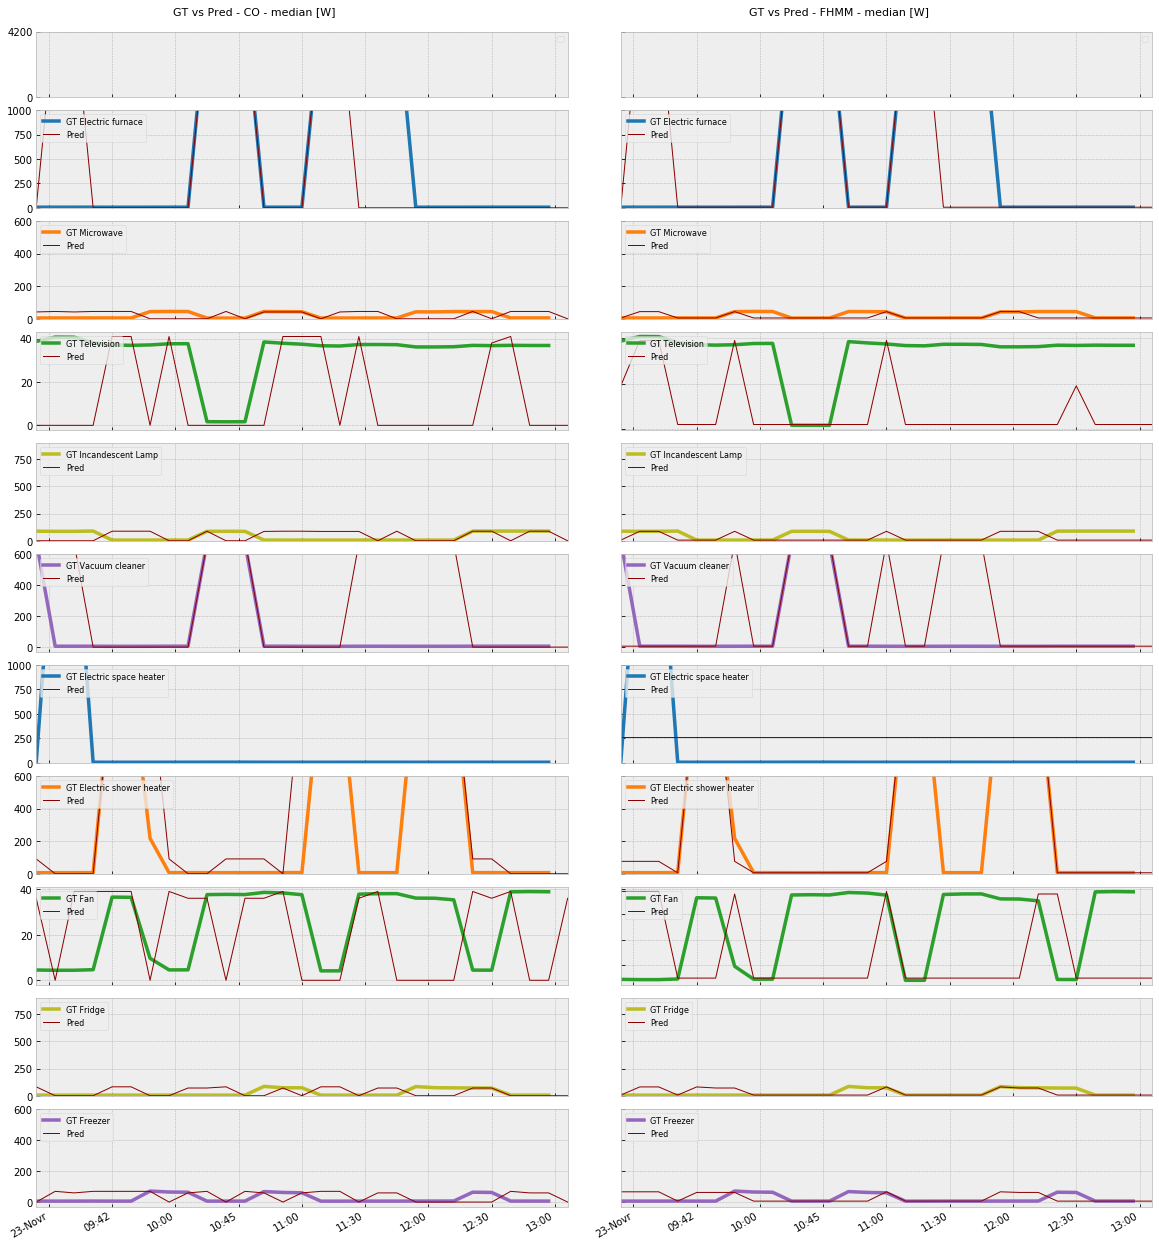

In [12]:
#resultados de predicción modelo CO 90s
CO_90s_first=DataSet(data_dir+'NILM/Results/CO_90s_median_pred.h5')
elec_CO_90s_first=CO_90s_first.buildings[1].elec
#resultados de predicción modelo FHMM 90s
FHMM_90s_first=DataSet(data_dir+'NILM/Results/FHMM_90s_median_pred.h5')
elec_FHMM_90s_first= FHMM_90s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=90, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_90s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_90s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='90s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['23-Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

## 5min 

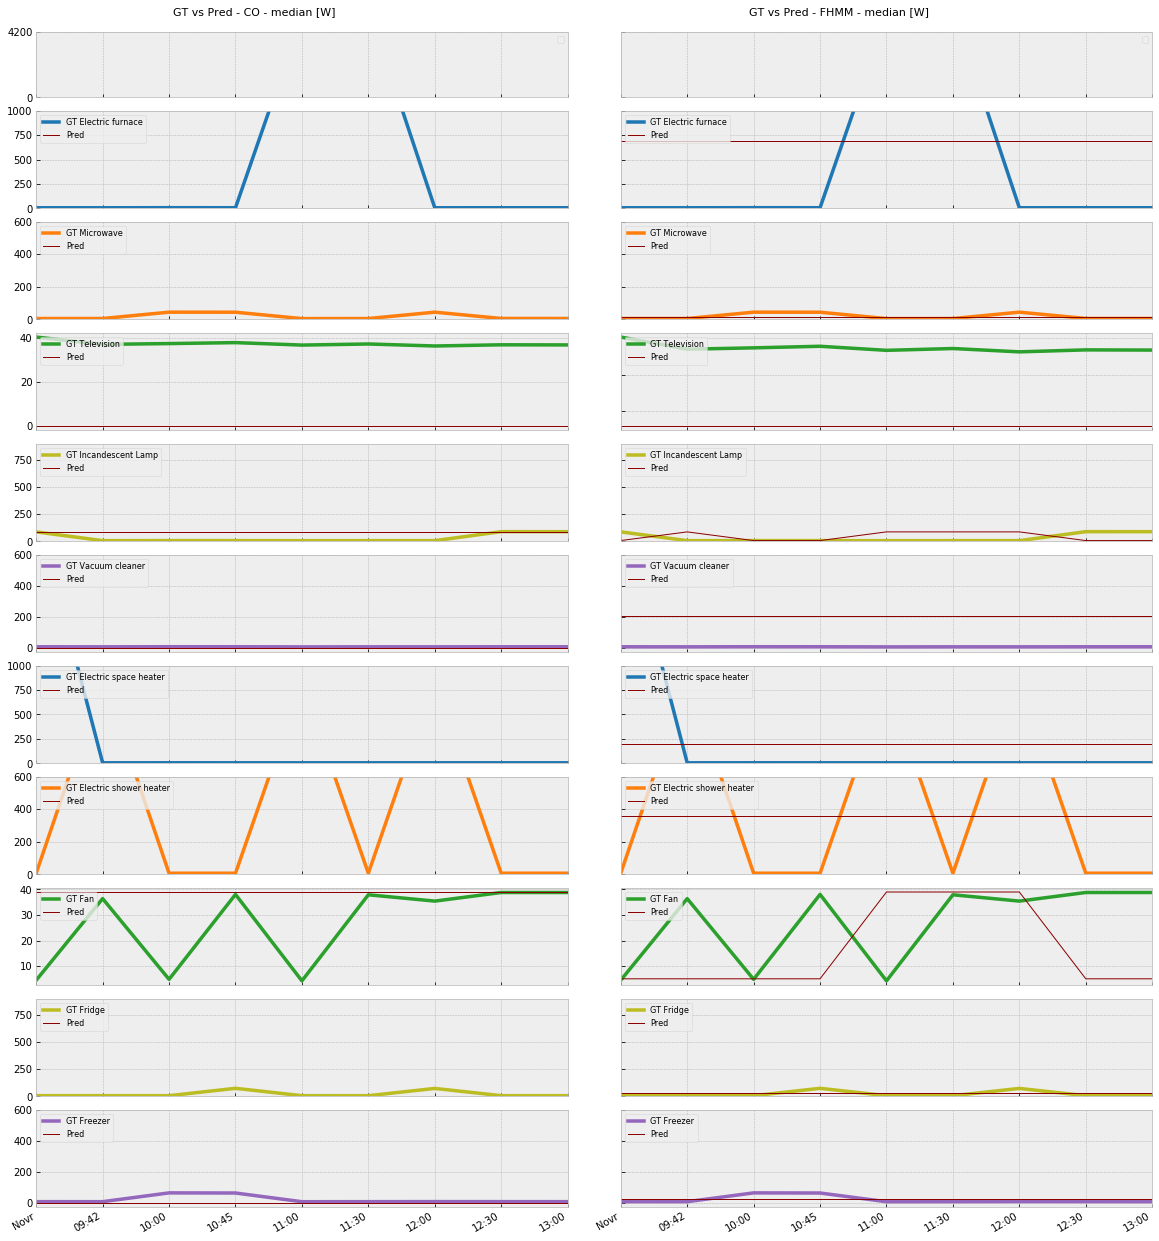

In [13]:
#resultados de predicción modelo CO 300s
CO_5min_first=DataSet(data_dir+'NILM/Results/CO_5min_median_pred.h5')
elec_CO_5min_first=CO_5min_first.buildings[1].elec

#resultados de predicción modelo FHMM 300s
FHMM_5min_first=DataSet(data_dir+'NILM/Results/FHMM_5min_median_pred.h5')
elec_FHMM_5min_first= FHMM_5min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=300, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_5min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_5min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='5min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_300s.svg', bbox_inches='tight', transparent=True)
pass

## 10 minutes

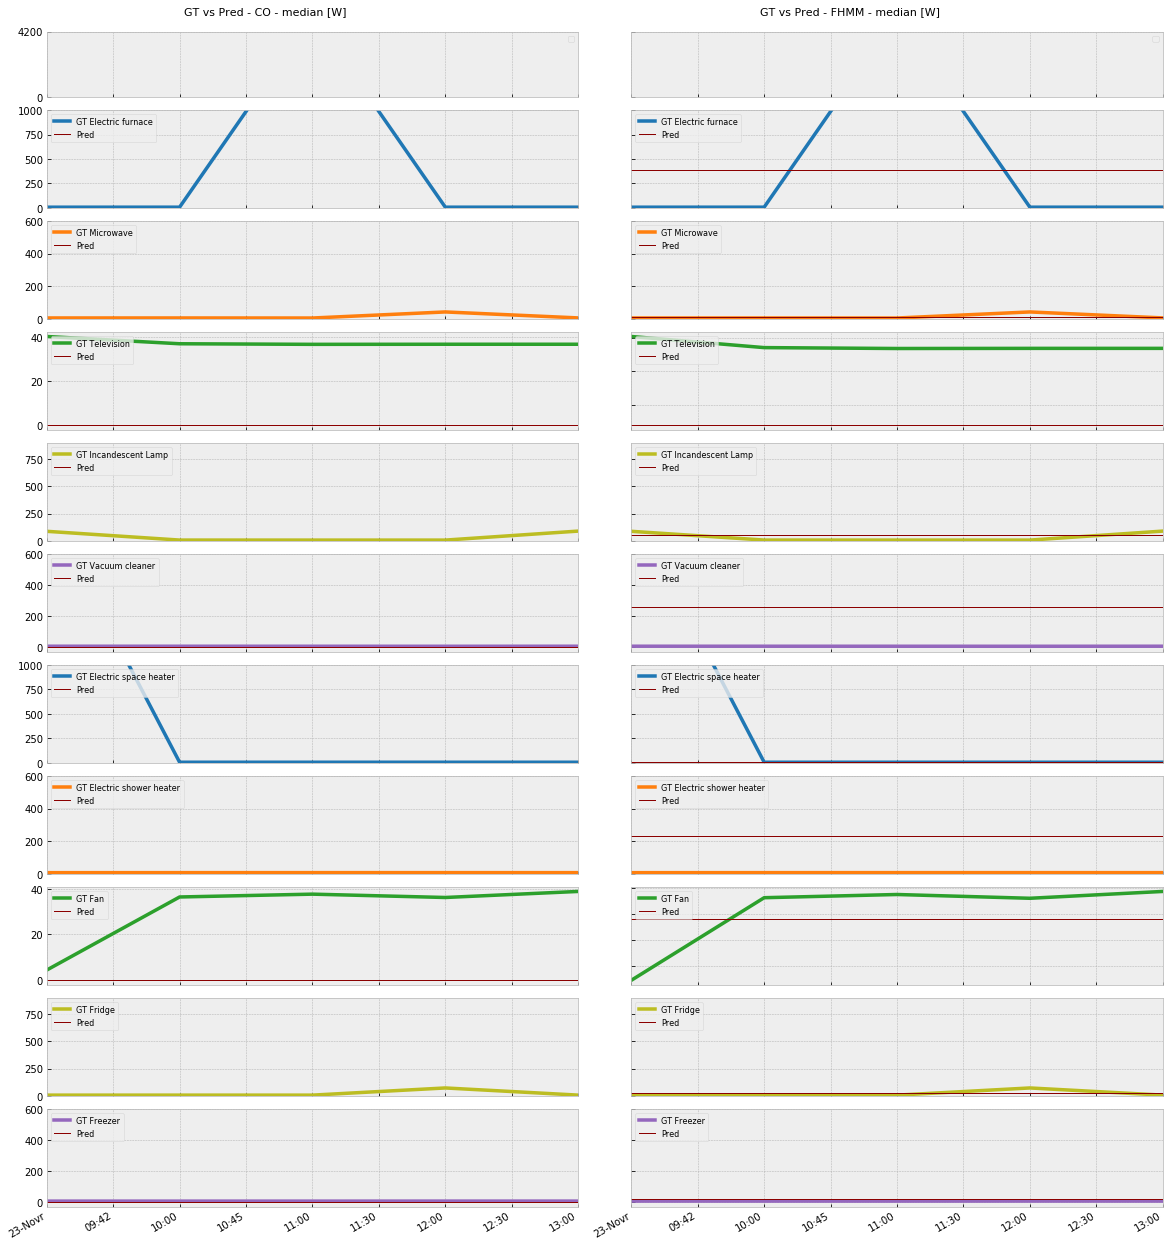

In [14]:
#resultados de predicción modelo CO 10min
CO_10min_first=DataSet(data_dir+'NILM/Results/CO_10min_median_pred.h5')
elec_CO_10min_first=CO_10min_first.buildings[1].elec

#resultados de predicción modelo FHMM 10min
FHMM_10min_first=DataSet(data_dir+'NILM/Results/FHMM_10min_median_pred.h5')
elec_FHMM_10min_first= FHMM_10min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=600, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_10min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_10min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='10min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['23-Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_900s.svg', bbox_inches='tight', transparent=True)
pass

##  first method

## 1 minutes

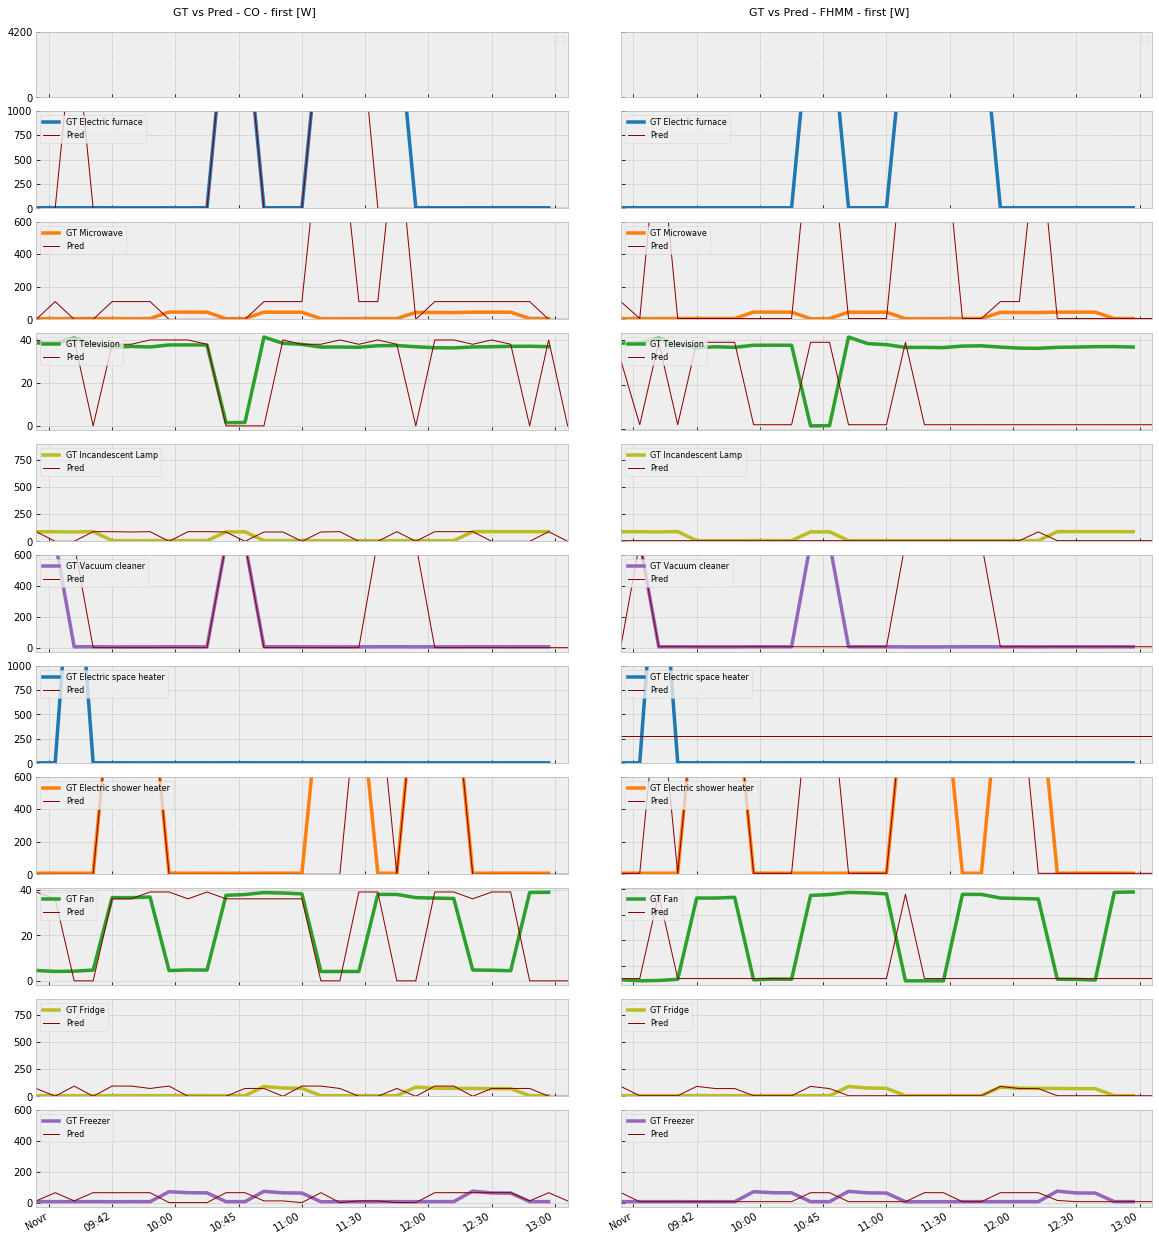

In [15]:
#resultados de predicción modelo CO 90s
CO_90s_first=DataSet(data_dir+'NILM/Results/CO_90s_first_pred.h5')
elec_CO_90s_first=CO_90s_first.buildings[1].elec

#resultados de predicción modelo FHMM 30s
FHMM_90s_first=DataSet(data_dir+'NILM/Results/FHMM_90s_first_pred.h5')
elec_FHMM_90s_first= FHMM_90s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=90, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_90s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_90s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='90s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      
      

for i in range(2):

    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

## 5 minutes

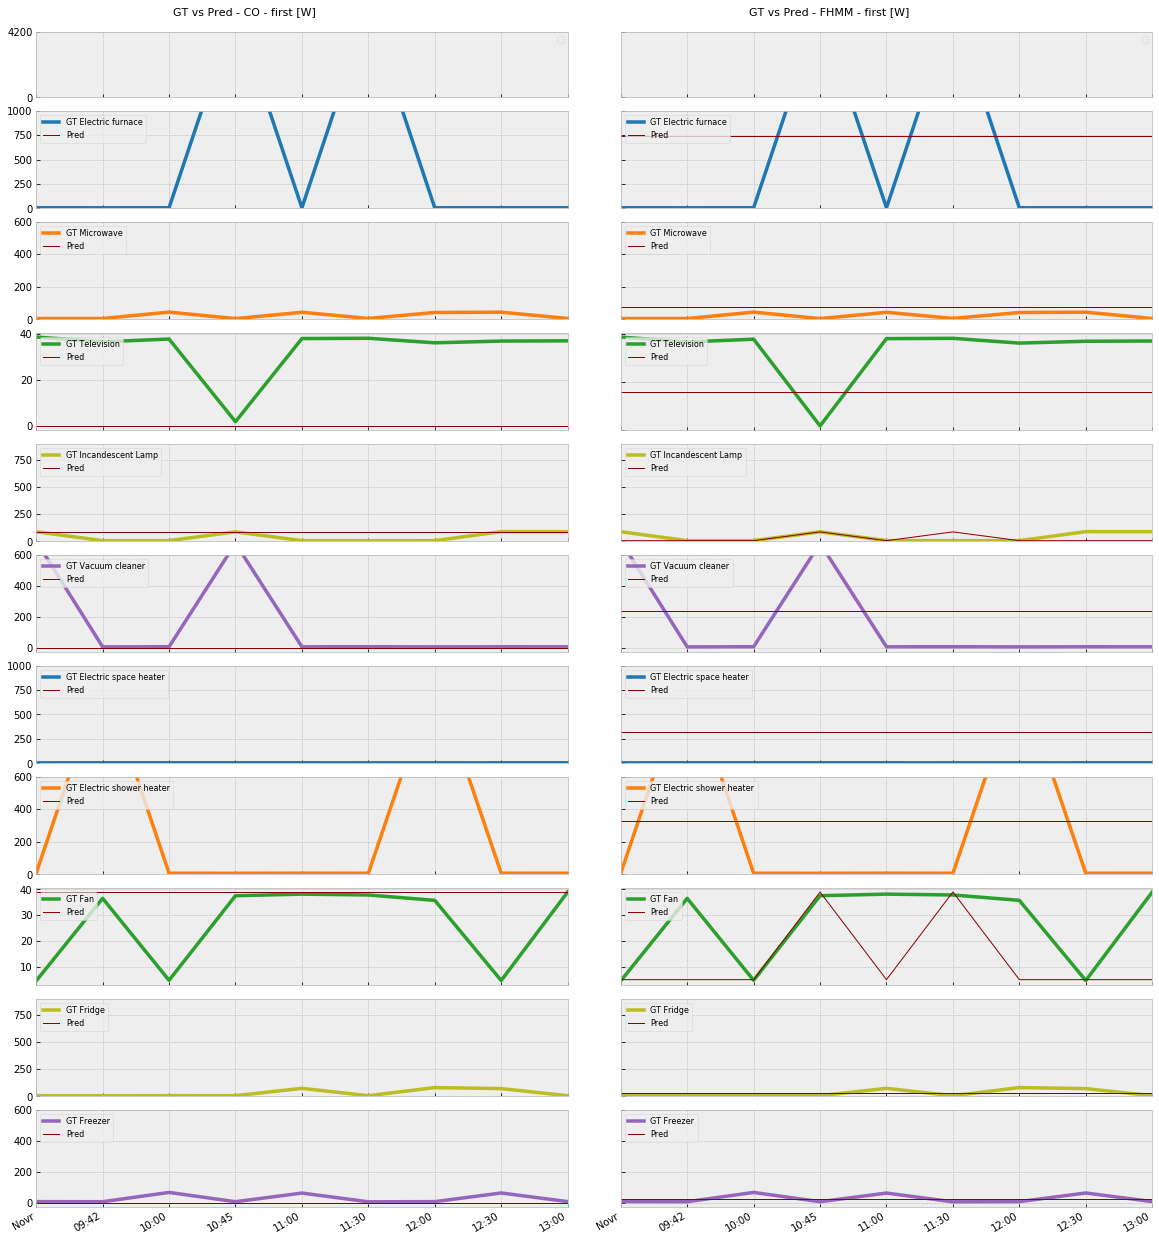

In [16]:
#resultados de predicción modelo CO 1s
CO_5min_first=DataSet(data_dir+'NILM/Results/CO_5min_first_pred.h5')
elec_CO_5min_first=CO_5min_first.buildings[1].elec

#resultados de predicción modelo FHMM 1s
FHMM_5min_first=DataSet(data_dir+'NILM/Results/FHMM_5min_first_pred.h5')
elec_FHMM_5min_first= FHMM_5min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=300, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_5min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_5min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='5min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 






for i in range(2):
   


    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_300s.svg', bbox_inches='tight', transparent=True)
pass

## 10 minutes

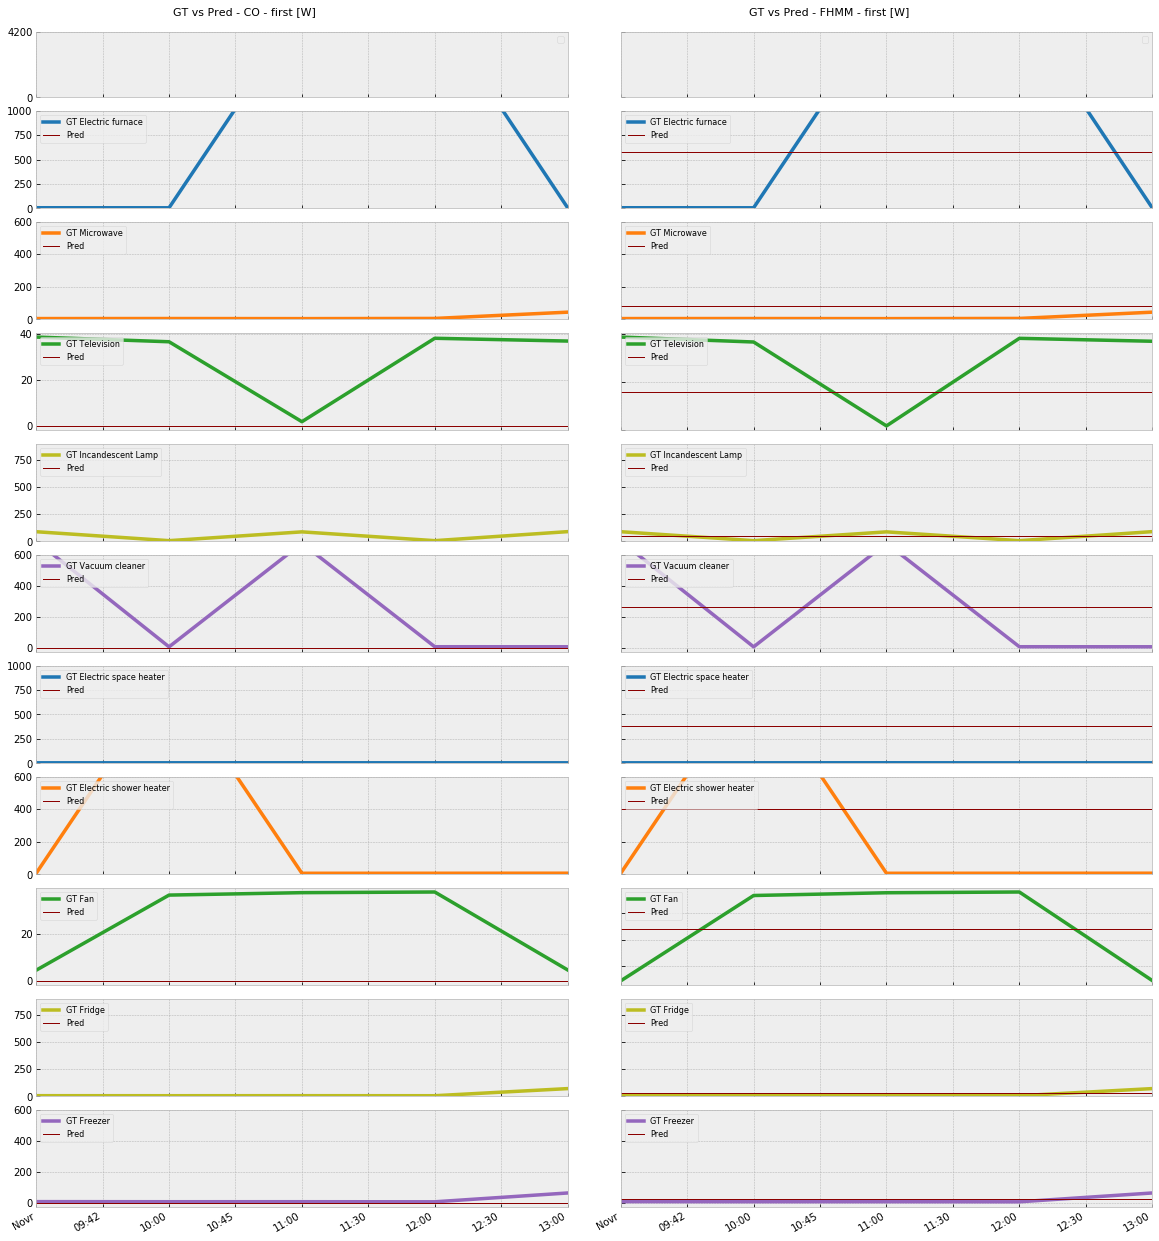

In [17]:
#resultados de predicción modelo CO 1s
CO_10min_first=DataSet(data_dir+'NILM/Results/CO_10min_first_pred.h5')
elec_CO_10min_first=CO_10min_first.buildings[1].elec

#resultados de predicción modelo FHMM 1s
FHMM_10min_first=DataSet(data_dir+'NILM/Results/FHMM_10min_first_pred.h5')
elec_FHMM_10min_first= FHMM_10min_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=600, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_10min_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_10min_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='10min'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 






for i in range(2):
   


    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Incandescent Lamp'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Incandescent Lamp'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Incandescent Lamp','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_900s.svg', bbox_inches='tight', transparent=True)
pass

## Comparison between validation set (GT) and predicted data

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='dsualmh', appliances=[Appliance(type='electric shower heater', instance=1)])
  El

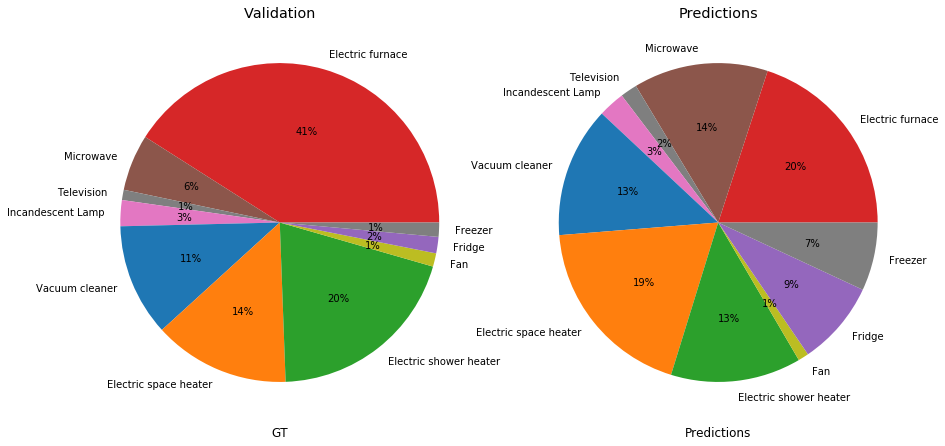

In [18]:
import matplotlib.pyplot as plt


#Set para validación
valid = DataSet('dsualmh.h5')
train.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")
valid_elec = valid.buildings[1].elec
print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)
print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
print(valid_Devices)


#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_1s_first_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec




# Separate the devices for predictions and validation
valid_Devices = valid_elec.submeters()
predictions_Devices = elec_CO_1s_first.submeters()

frac_1 = valid_Devices.fraction_per_meter()
frac_2 = predictions_Devices.fraction_per_meter()




rcParams['figure.figsize'] = (38, 35)
# Create separate subplots for the two pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(38, 35), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Plot the first pie chart (Validation)
frac_1.plot(autopct=lambda p: f'{p:.0f}%', kind='pie', labels=list(Meters.values())[1:12], figsize=(15, 15), ax=ax1, colors=['tab:red', 'tab:brown', 'tab:gray', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:purple', 'tab:grey', 'tab:brown'])
#frac_1.plot(autopct=lambda p: '{:.0f}%'.format(p), kind='pie', labels=list(Meters.values())[1:12], ax=ax1, colors=['tab:red','tab:brown','tab:gray','tab:pink','tab:blue','tab:orange','tab:green','tab:yellow','tab:black','tab:purple','tab:grey','tab:brown'])
ax1.set(ylabel="")
ax1.set(xlabel="GT")
ax1.set_title("Validation")

# Plot the second pie chart (Predictions)
#frac_2.plot(autopct=lambda p: '{:.0f}%'.format(p), kind='pie', labels=list(Meters.values())[1:12], ax=ax2, colors=['tab:red','tab:brown','tab:gray','tab:pink','tab:blue','tab:orange','tab:green','tab:yellow','tab:black','tab:purple','tab:grey','tab:brown'])
frac_2.plot(autopct=lambda p: f'{p:.0f}%', kind='pie', labels=list(Meters.values())[1:12], figsize=(15, 15), ax=ax2, colors=['tab:red', 'tab:brown', 'tab:gray', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:purple', 'tab:grey', 'tab:brown'])
ax2.set(ylabel="")
ax2.set(xlabel="Predictions")
ax2.set_title("Predictions")

# Save the figure
plt.savefig('./data/images/5.4_FEAC_CO_1s.svg', bbox_inches='tight', transparent=True)
plt.show()

### The same result but with more condensed graphics

10/10 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])=1)])

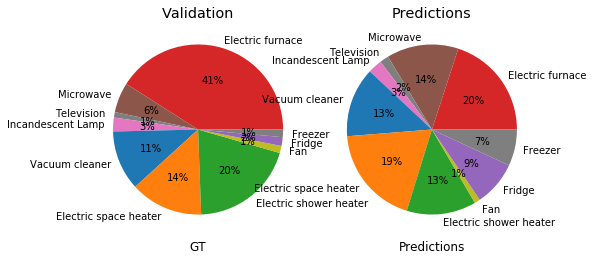

In [19]:
import matplotlib.pyplot as plt


# Separate the devices for predictions and validation
#valid_Devices = elec_CO_1s_first.submeters()

#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_1s_first_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
predictions_Devices = elec_CO_1s_first.submeters()


#Set para validación
valid = DataSet('dsualmh.h5')
train.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")
valid_elec = valid.buildings[1].elec


frac_1 = valid_Devices.fraction_per_meter()
frac_2 = predictions_Devices.fraction_per_meter()

# Create separate subplots for the two pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Plot the first pie chart (Validation)
frac_1.plot(autopct=lambda p: f'{p:.0f}%', kind='pie', labels=list(Meters.values())[1:12], figsize=(8, 8), ax=ax1, colors=['tab:red', 'tab:brown', 'tab:gray', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:purple', 'tab:grey', 'tab:brown'])
ax1.set(ylabel="")
ax1.set(xlabel="GT")
ax1.set_title("Validation")

# Plot the second pie chart (Predictions)
frac_2.plot(autopct=lambda p: f'{p:.0f}%', kind='pie', labels=list(Meters.values())[1:12], figsize=(8, 8), ax=ax2, colors=['tab:red', 'tab:brown', 'tab:gray', 'tab:pink', 'tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:purple', 'tab:grey', 'tab:brown'])
ax2.set(ylabel="")
ax2.set(xlabel="Predictions")
ax2.set_title("Predictions")

# Save the figure
plt.savefig('./data/images/5.4_FEAC_CO_1s.svg', bbox_inches='tight', transparent=True)
plt.show()